In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jieba
import string

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model, to_categorical
from keras.models import Model
from keras.layers import Input, Dense, LSTM
from keras.layers import Embedding

from IPython.display import Image

Using TensorFlow backend.


In [2]:
class Param():
    batch_size = 32
    n_epoch = 50
    seq_length = 20
    metadata = 'metadata.tsv'
    n_step = 3
    n_batches_per_epoch = 500
    lyrics_long = 360

    
    remove_word = ['!', '(', ')', '*', '+', ',', '-', '.',
                   '...', '......', '............', '/','<',
                   '>', '?','[', '\\', ']', '`','~', '·',
                   '…', '☆', '\u3000', '。', '〇', '《', '》',
                   '〖', '〗', 'ー', 'ㄇ', 'ㄈ', 'ㄌ', 'ㄒ', 'ㄙ','！',
                   'ㄚ', 'ㄟ', 'ㄡ','（','）','，','＜','＞','？','～']   

In [3]:
class DataGenerator():
    def __init__(self, datafiles, args):
        self.seq_length = args.seq_length
        self.batch_size = args.batch_size
        self.n_step = args.n_step
        
        self.remove_word = args.remove_word
        self.remove_word = ''.join(self.remove_word)        
        
        with open(datafiles, encoding='utf-8') as f:
            self.data = f.read()
        
        table = str.maketrans('','',self.remove_word)
        self.data = [w.translate(table) for w in self.data]
                
        # total data length
        self.total_len = len(self.data)  
        self.words = list(set(self.data))
        self.words.sort()
        print('Total length: {}'.format(self.total_len))
        
        # vocabulary
        self.vocab_size = len(self.words)  # vocabulary size
        print('Vocabulary Size:', self.vocab_size)
        
        # dictionary
        self.char2id_dict = {w: i for i, w in enumerate(self.words)}
        self.id2char_dict = {i: w for i, w in enumerate(self.words)}
        
        # pointer position to generate current batch
        self._pointer = 0
        # save metadata file
        self.save_metadata(args.metadata)
        
        self.max_iter = args.n_epoch * \
            (self.total_len // args.seq_length) // args.batch_size
        
    def char2id(self, c):
        return self.char2id_dict[c]
    
    def id2char(self, id):
        return self.id2char_dict[id]
    
    def save_metadata(self, file):
        with open(file, 'w', encoding="utf-8") as f:
            f.write('id\tchar\n')
            for i in range(self.vocab_size):
                c = self.id2char(i)
                f.write('{}\t{}\n'.format(i, c))
                
#     def create_tokenizer(self):
#         tokenizer = Tokenizer()
#         tokenizer.fit_on_texts(self.seg_list)
#         return tokenizer
    
    def next_batch(self):
        x_batches = []
        y_batches = []
        for i in range(self.batch_size):
            if self._pointer + self.seq_length + 1 >= self.total_len:
                self._pointer = 0

            bx = self.data[self._pointer: self._pointer + self.seq_length]
#             by = self.seg_list[self._pointer +
#                            1: self._pointer + self.seq_length + 1]
            by = self.data[self._pointer + self.seq_length]

            # update pointer position
            self._pointer += 1

            # convert to ids
            bx = [self.char2id(c) for c in bx]
            by = [self.char2id(by)]

            by = to_categorical(by, num_classes=self.vocab_size)[0]

            x_batches.append(bx)
            y_batches.append(by)
        
        return x_batches, y_batches
    
    
    def data_generator(self):
        while 1:
        # loop over photo identifiers in the dataset

            for i in range(0, self.max_iter, self.n_step):
                XSeq, y = list(), list()
                for j in range(i, min(self.max_iter, i+self.n_step)):

                    # generate input-output pairs
                    in_seq, out_word = self.next_batch()

                    for k in range(len(in_seq)):
                        XSeq.append(in_seq[k])
                        y.append(out_word[k])
                # yield this batch of samples to the model
                yield [np.array(XSeq), np.array(y)]

In [4]:
def define_model(args, data):

    # embedding
    inputs = Input(shape=(args.seq_length,))
    emb2 = Embedding(data.vocab_size, 50, mask_zero=True)(inputs)
    emb3 = LSTM(256)(emb2)

    # language model (decoder)
#     lm2 = LSTM(256)(emb3)
    lm3 = Dense(500, activation='relu')(emb3)
    outputs = Dense(data.vocab_size, activation='softmax')(lm3)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='plot.png')

    return model

In [5]:
lyrics = "jaychou_lyrics_traditional.txt"

args = Param()
data = DataGenerator(lyrics, args)

Total length: 64925
Vocabulary Size: 2469


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20, 50)            123450    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               128500    
_________________________________________________________________
dense_2 (Dense)              (None, 2469)              1236969   
Total params: 1,803,287
Trainable params: 1,803,287
Non-trainable params: 0
_________________________________________________________________
None


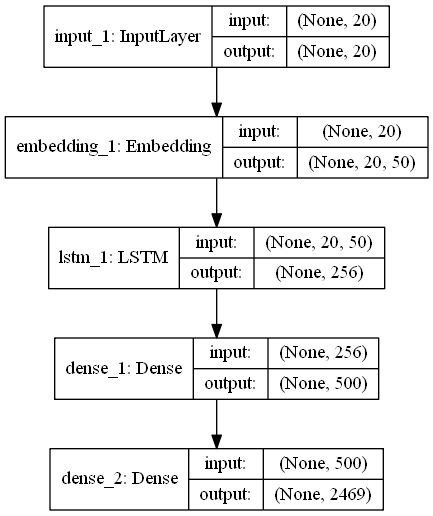

In [6]:
model = define_model(args, data)
Image('plot.png')

In [7]:
model.fit_generator(data.data_generator(), steps_per_epoch=args.n_batches_per_epoch, 
                    epochs=20, verbose=2)

Epoch 1/20
 - 77s - loss: 6.2167 - acc: 0.1322
Epoch 2/20
 - 72s - loss: 5.8695 - acc: 0.1330
Epoch 3/20
 - 73s - loss: 5.6713 - acc: 0.1495
Epoch 4/20
 - 69s - loss: 5.5210 - acc: 0.1472
Epoch 5/20
 - 73s - loss: 5.2449 - acc: 0.1490
Epoch 6/20
 - 72s - loss: 5.0972 - acc: 0.1529
Epoch 7/20
 - 73s - loss: 4.9417 - acc: 0.1656
Epoch 8/20
 - 70s - loss: 4.8810 - acc: 0.1674
Epoch 9/20
 - 66s - loss: 4.6883 - acc: 0.1793
Epoch 10/20
 - 66s - loss: 4.5688 - acc: 0.1872
Epoch 11/20
 - 73s - loss: 4.4508 - acc: 0.2036
Epoch 12/20
 - 72s - loss: 4.3728 - acc: 0.2070
Epoch 13/20
 - 62s - loss: 4.1405 - acc: 0.2278
Epoch 14/20
 - 65s - loss: 4.0368 - acc: 0.2398
Epoch 15/20
 - 67s - loss: 3.9687 - acc: 0.2495
Epoch 16/20
 - 66s - loss: 3.8736 - acc: 0.2601
Epoch 17/20
 - 66s - loss: 3.5967 - acc: 0.2918
Epoch 18/20
 - 69s - loss: 3.5759 - acc: 0.2978
Epoch 19/20
 - 66s - loss: 3.5509 - acc: 0.3020
Epoch 20/20
 - 64s - loss: 3.3622 - acc: 0.3268


In [9]:
# generate a description for an image
def generate_desc(model, args, data, in_text):
    # seed the generation process

    generated = ''
    generated += in_text

    # iterate over the whole length of the sequence
    for i in range(args.lyrics_long):
        # integer encode input sequence

        in_seq = [data.char2id(c) for c in in_text]

        # pad input
        sequence = pad_sequences([in_seq], maxlen=data.seq_length)
        # predict next word
        yhat = model.predict(sequence, verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = data.id2char(yhat)
        # stop if we cannot map the word
#         if word is None:
#             break
        # append as input for generating the next word
        
        generated += word
        in_text = in_text[1:]+word


        # stop if we predict the end of the sequence
        # if word == 'endseq':
        #     break
    return generated

In [10]:
model.save('D:/Program/train_model/lyrics_generator/m1.h5')

In [23]:
in_text = '哥只是'

generate_desc(model, args, data,in_text)

'哥只是我給你的時間 你我不能我說你不見你 你微笑 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不過 你不會去 你們不'